In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import psycopg2 
import io
import matplotlib.pyplot as plt

# Trail Metadata

In [2]:
trail_info = pd.read_pickle('/Users/briangraham/insight/trailrec/data/trail_info_combined.pickle')
trail_info.head()

,Altitude change,Altitude end,Altitude max,Altitude min,Altitude start,Avg reverse time,Avg time,Bike type,Difficulty rating,Direction,...,Distance flat,Family Friendly,Year Opened,Season,AKA,Land Manager,Voted Difficulty,eBike Allowed,OSM Way,Alpine Trail
trail_id,,,,,,,,,,,,,,,,,,,,,
1-87-dh,"-1,508 ft",349 ft,"1,857 ft",349 ft,"1,857 ft",00:01:40,00:12:58,"DH, AM",Black Diamondrate,Downhill Primary,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10-50,-84 ft,818 ft,904 ft,772 ft,901 ft,00:11:07,00:10:24,XC,Greenrate,Both Directions,...,221 ft,Yes,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10-dollar,-191 ft,"2,446 ft","2,636 ft","2,446 ft","2,636 ft",00:15:47,00:09:03,"DH, AM, XC",Bluerate,NaN,...,76 ft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10-km,-694 ft,"4,931 ft","5,625 ft","4,918 ft","5,625 ft",NaN,00:06:44,DH,Black Diamondrate,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10-licks,135 ft,750 ft,797 ft,614 ft,614 ft,NaN,00:18:47,"AM, XC",Bluerate,NaN,...,151 ft,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
trail_info.shape

(3935, 44)

In [4]:
percent_missing = trail_info.isnull().sum()/trail_info.shape[0]*100
observations = trail_info.notnull().sum()
trail_info_observation_stats = pd.DataFrame({'observations':observations,'percent_missing':percent_missing})
trail_info_observation_stats

,observations,percent_missing
Altitude change,3920,0.381194
Altitude end,3935,0.000000
Altitude max,3642,7.445997
Altitude min,3935,0.000000
Altitude start,3935,0.000000
Avg reverse time,2055,47.776366
Avg time,3642,7.445997
Bike type,3465,11.944091
Difficulty rating,3935,0.000000
Direction,1303,66.886912


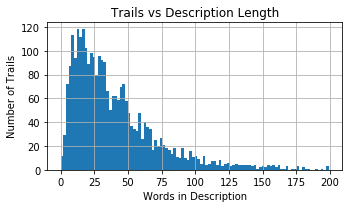

In [45]:
# Amount of words in descriptions
# 28% of ~4k files were missing descriptions
description_length = trail_info['description'].str.len()
description_length = trail_info['description'].str.count(' ')
description_length[description_length<200].hist(bins = 100,figsize=(5,3))
plt.xlabel('Words in Description')
plt.ylabel('Number of Trails')
plt.title('Trails vs Description Length')
plt.tight_layout()
plt.savefig('hist_words_per_trail_description.png')

# Comment Data 

In [6]:
comment_info = pd.read_pickle('/Users/briangraham/insight/trailrec/data/trail_comments_combined.pickle')
comment_info.shape

(1848, 3)

Text(0.5,1,'Distribution of number of comments')

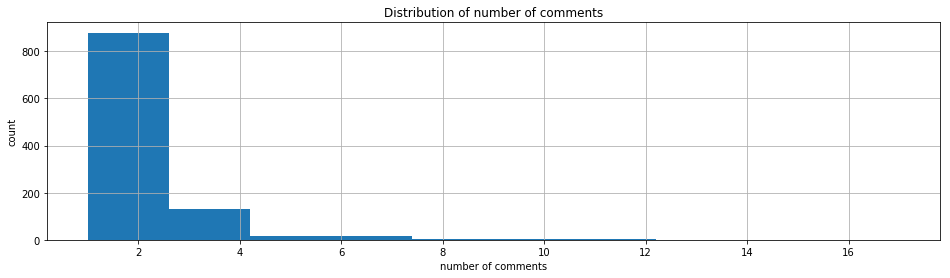

In [7]:
comment_count = comment_info.groupby('trail_id').count()
comment_count['comment_text'].hist(figsize=(16,4))
plt.xlabel('number of comments')
plt.ylabel('count')
plt.title('Distribution of number of comments')

# Ridelog Data

In [8]:
ridelogs = pd.read_pickle('/Users/briangraham/insight/trailrec/data/trail_ridelogs_combined.pickle')

In [9]:
ridelogs.tail()

,ride_date,rider_url,rider_name,rider_state,rider_city,ride_difficulty_string
trail_id,,,,,,
zoso,"Jul 16, 2016",https://www.trailforks.com/profile/remoh/,remoh,BC,Victoria,Very Difficult / Black Diamond
zoso,"Jul 15, 2016",https://www.trailforks.com/profile/tbryn/,tbryn,BC,Victoria,Intermediate / Blue Square
zoso,"Jul 6, 2016",https://www.trailforks.com/profile/skenny1/,skenny1,BC,Victoria,Intermediate / Blue Square
zoso,"Jul 5, 2016",https://www.trailforks.com/profile/highrocker1...,highrocker1298,BC,Victoria,Intermediate / Blue Square
zoso,"Aug 30, 2015",https://www.trailforks.com/profile/katerodoruk/,katerodoruk,BC,Victoria,Intermediate / Blue Square


In [10]:
ridelog_count = ridelogs.groupby('trail_id').count()
ridelogs.shape

(1589860, 6)

Text(0.5,1,'Distribution of number of number of rides per trail')

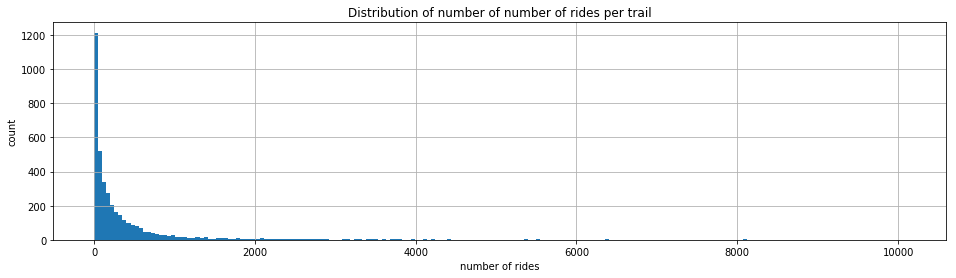

In [11]:
ridelog_count['ride_date'].hist(bins = 200,figsize=(16,4))
plt.xlabel('number of rides')
plt.ylabel('count')
plt.title('Distribution of number of number of rides per trail')

(0, 2000)

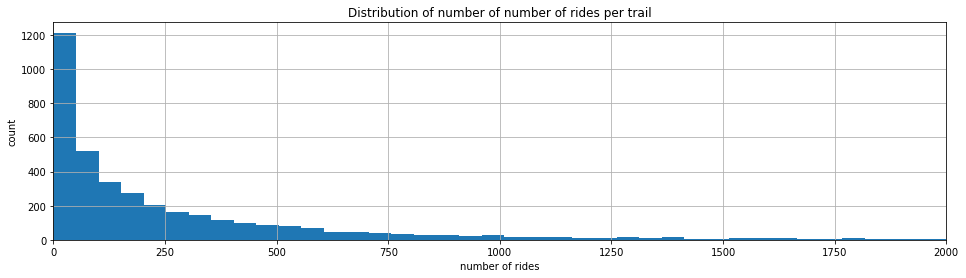

In [12]:
ridelog_count['ride_date'].hist(bins = 200,figsize=(16,4))
plt.xlabel('number of rides')
plt.ylabel('count')
plt.title('Distribution of number of number of rides per trail')
plt.xlim([0,2000])

Text(0.5,1,'Distribution of rides by riders')

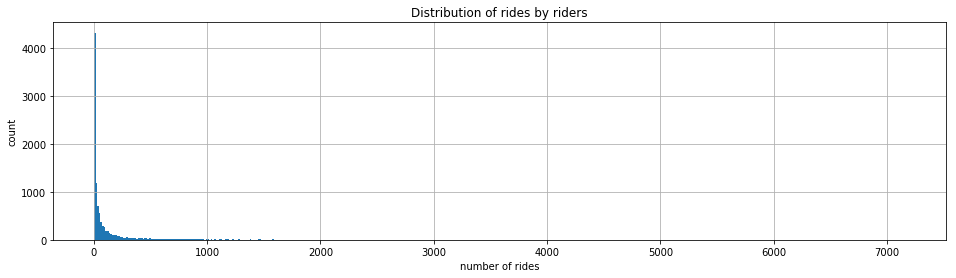

In [13]:
rider_count = ridelogs.groupby('rider_name').count()
rider_count['ride_date'].hist(bins = 500,figsize=(16,4))
plt.xlabel('number of rides')
plt.ylabel('count')
plt.title('Distribution of rides by riders')

(0, 2000)

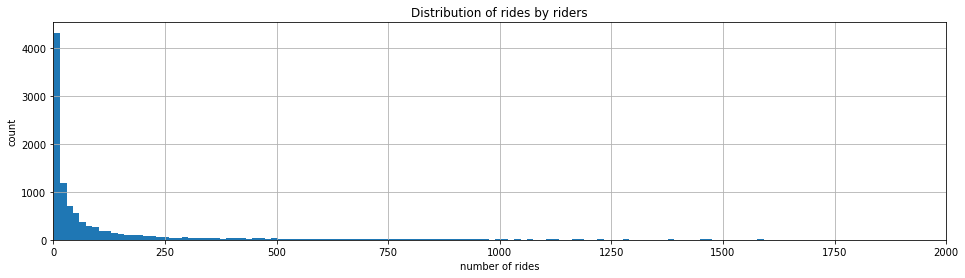

In [14]:
rider_count = ridelogs.groupby('rider_name').count()
rider_count['ride_date'].hist(bins = 500,figsize=(16,4))
plt.xlabel('number of rides')
plt.ylabel('count')
plt.title('Distribution of rides by riders')
plt.xlim([0,2000])

In [15]:
df_rides = ridelogs[['ride_date','rider_name']]
unique_rides = df_rides.reset_index().groupby('rider_name').nunique().sort_values('trail_id',ascending=False)

In [16]:
unique_rides.head()

,trail_id,ride_date,rider_name
rider_name,,,
canadaka,1076,762,1
BCpov,904,564,1
DoubleDog,724,672,1
campasternak,690,370,1
Sniper593,683,334,1


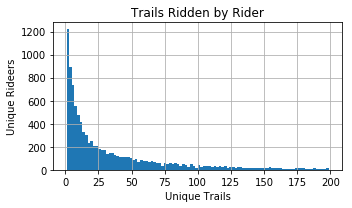

In [40]:
unique_rides[unique_rides['trail_id'] < 200 ].hist(column='trail_id',bins=100,figsize = (5,3))
plt.xlabel('Unique Trails')
plt.ylabel('Unique Rideers')
plt.title('Trails Ridden by Rider')
plt.tight_layout()
plt.savefig('hist_rider_trail.png')

In [18]:
# Number of riders with more than 50 unique trails
np.sum([unique_rides['trail_id'] > 50])

2757

In [19]:
# Number of riders with more than 20 unique trails
np.sum([unique_rides['trail_id'] > 20])

4902

In [20]:
# Number of riders with more than 10 unique trails
np.sum([unique_rides['trail_id'] > 10])

6426